##### **Importing required libraries**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import zipfile
import os
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Embedding, LSTM, Dense, Flatten, Input
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.callbacks import Callback
import nltk.translate.bleu_score as bleu
from keras.utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
import nltk
nltk.__version__

'3.8.1'

In [5]:
# Extracting all data files from downloaded zip file
with zipfile.ZipFile('/content/drive/MyDrive/Language_translation/parallel.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [6]:
# Reading the data from the file and storing english text data in the list.

en_data_list = []
with open('/content/parallel-n/IITB.en-hi.en', "r", encoding="utf-8") as file:
    for line in file:
        en_data_list.append(line.strip())

In [7]:
en_data_list

['Give your application an accessibility workout',
 'Accerciser Accessibility Explorer',
 'The default plugin layout for the bottom panel',
 'The default plugin layout for the top panel',
 'A list of plugins that are disabled by default',
 'Highlight duration',
 'The duration of the highlight box when selecting accessible nodes',
 'Highlight border color',
 'The color and opacity of the highlight border.',
 'Highlight fill color',
 'The color and opacity of the highlight fill.',
 'API Browser',
 'Browse the various methods of the current accessible',
 'Hide private attributes',
 'Method',
 'Property',
 'Value',
 'IPython Console',
 'Interactive console for manipulating currently selected accessible',
 'Event monitor',
 '_ Monitor Events',
 'C _ lear Selection',
 'Everything',
 'Selected application',
 'Selected accessible',
 'Source',
 'Event Monitor',
 'Shows events as they occur from selected types and sources',
 'Highlight last event entry',
 'Start / stop event recording',
 'Clear 

In [8]:
# Reading the data from the file and storing hindi text data in the list.

hin_data_list = []
with open('/content/parallel-n/IITB.en-hi.hi', "r", encoding="utf-8") as file:
    for line in file:
        hin_data_list.append(line.strip())

In [9]:
hin_data_list

['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
 'एक्सेर्साइसर पहुंचनीयता अन्वेषक',
 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका',
 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका',
 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है',
 'अवधि को हाइलाइट रकें',
 'पहुंचनीय आसंधि (नोड) को चुनते समय हाइलाइट बक्से की अवधि',
 'सीमांत (बोर्डर) के रंग को हाइलाइट करें',
 'हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता।',
 'भराई के रंग को हाइलाइट करें',
 'हाइलाइट किया गया भराई का रंग और पारदर्शिता।',
 'एपीआई विचरक',
 'इस समय जिसे प्राप्त किया गया हो, उसकी विभिन्न विधियों (मेथड) में विचरण करें',
 'निजी गुणों को छिपाएं',
 'विधि',
 'गुणधर्म',
 'मान',
 'आईपाइथन कन्सोल',
 'इस समय चुने गए एक्सेसेबेल से काम लेने के लिए अंतर्क्रियात्मक कन्सोल',
 'घटना मानिटर',
 'घटनाओं को मानिटर करें (_ M)',
 'चुनाव को हटाएं (C _)',
 'सभी',
 'चुने गए अनुप्रयोग',
 'चुने गए एक्सेसेबेल',
 'स्रोत',
 'घटना मानिटर',
 'चुने गए प्रकारों और स्रोतों से घटनाएं जैसे-जैसे घटित होती हैं, उन्हें दर्शाता है',
 'अंतिम प्रविष्ट घटना को

In [10]:
# checking the length of the text data in the english language list.
len(en_data_list)

1659083

In [11]:
# checking the length of the text data in the hindi language list.
len(hin_data_list)

1659083

There are 1.659083 million data points in both the English and Hindi languages

In [12]:
# Creating a dataframe from english and hindi text data.

data  = pd.DataFrame(list(zip(en_data_list,hin_data_list)),columns = ['english','hindi'])
data.head() # Displaying the first 5 rows of the data.

,english,hindi
0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका
3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका
4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...


In [13]:
# Sampling 5000 datapoints from the original data
sample_data = data.sample(5000,random_state=24).reset_index(drop=True)

In [14]:
# Displaying the first 5 rows of the sampled data
sample_data.head()

,english,hindi
0,"And we look for a link and, bang, it found one.","और हम एक लिंक देखने और, धमाके, यह एक मिल गया।"
1,"He is Allah: there is no god but He: the King,...",वही वह ख़ुदा है जिसके सिवा कोई क़ाबिले इबादत न...
2,The solubility of the powder is being tested.,पाउडर की विलयनशीलता का परीक्षण किया जा रहा है।
3,"Had they been gods, they would not have entere...",अगर ये (सच्चे) माबूद होते तो उन्हें दोज़ख़ में...
4,Surely (as for) those who believe and do good ...,निश्चय ही जो लोग ईमान लाए और उन्होंने अच्छे कर...


In [15]:
# decontractions -  This function takes phrase in english language as input
# and replaces contractions in the phrase with their expanded forms. For example, "won't" would be replaced
# with "will not". It uses a dictionary called contractions to map contractions to their expansions.

def decontractions(phrase):

    # decontractions for english language
    contractions = {
            "won't": "will not",
            "can't": "can not",
            "n't": " not",
            "'re": " are",
            "'s": " is",
            "'d": " would",
            "'ll": " will",
            "'t": " not",
            "'ve": " have",
            "'m": " am"
                    }
    for contraction, replacement in contractions.items():
        phrase = re.sub(contraction, replacement, phrase)
    return phrase

# preprocess - This function performs preprocessing tasks on a given text based
# on the specified language. First, it converts the text to lowercase. Then,
# it calls decontractions to expand contractions if any. Depending on the language,
# it applies specific regular expressions to clean the text from unwanted characters
# such as punctuation and special symbols. After that, it removes single-letter words
# and stopwords (commonly occurring words like "the", "is", "and", etc.) using
# language-specific stopwords lists obtained from NLTK's stopwords module.
# The preprocessed text is then returned.

def preprocess(text, language):

    if language == 'en':
        text = text.lower() # converts the text to lower case.
        text = decontractions(text) # applies the function decontractions on the text.
        text = re.sub('[^A-Za-z]+', ' ', text) # removes all non-alphabetic characters
                                              # from the text string, leaving only letters
                                              # (either uppercase or lowercase).
        text = ' '.join([word for word in text.split() if len(word) > 1]) # Removing single-letter words.
        stop_words = set(stopwords.words('english')) # extracting stopwords from english language
        text = ' '.join([word for word in text.split() if word not in stop_words]) # removes stopwords from
                                                                               # the text string and joins
                                                                               # the remaining words into a
                                                                               # single string separated by spaces.
        return text

    else:
        hindi_words = re.compile(r'[\u0900-\u097F]+').findall(text) # Regular expression to match Hindi words
                                                                    # and returns in the form of list
        text        = ' '.join(hindi_words)                         # converts list of words to string
        text        = text.replace('।','')                          # Replacing | in hindi sentences with empty space
        text    = ' '.join([word for word in text.split() if len(word) > 1]) # Removing single-letter words.
        stop_words = []
        # extracting stopwords from hindi language
        with open('/content/drive/MyDrive/Language_translation/stopwords.txt', "r", encoding="utf-8") as file:
            for line in file:
                stop_words.append(line.strip())
        stop_words = set(stop_words)
        text = ' '.join([word for word in text.split() if word not in stop_words]) # removes stopwords from
                                                                               # the text string and joins
                                                                               # the remaining words into a
                                                                               # single string separated by spaces.
        return text


In [16]:
# Creating a dataframe copy
cleaned_data = sample_data.copy()

In [17]:
# Applying the preprocess function to english and hindi columns.
cleaned_data['hindi']   = sample_data['hindi'].progress_apply(preprocess,language='hin')
cleaned_data['english'] = sample_data['english'].progress_apply(preprocess,language='en')

100%|██████████| 5000/5000 [00:00<00:00, 7520.23it/s]


In [18]:
# Displaying the first 5 rows of the data from the cleaned data
cleaned_data.head()

,english,hindi
0,look link bang found one,लिंक देखने धमाके मिल
1,allah god king holy peace giver security overs...,वही ख़ुदा जिसके सिवा क़ाबिले इबादत नहीं हक़ीक़...
2,solubility powder tested,पाउडर विलयनशीलता परीक्षण
3,gods would entered remain forever,सच्चे माबूद दोज़ख़ जाना पड़ता सबके सब हमेशा रह...
4,surely believe good deeds place entertainment ...,निश्चय लोग ईमान लाए उन्होंने अच्छे कर्म आतिथ्य...


In [19]:
# English Text after cleaning and processing the data
list(cleaned_data.english)

['look link bang found one',
 'allah god king holy peace giver security overseer mighty overpowering great exalted whatever associate',
 'solubility powder tested',
 'gods would entered remain forever',
 'surely believe good deeds place entertainment shall gardens paradise',
 'rashtriya uchchatar shiksha abhiyan rusa important initiative direction',
 'balloon payload brought',
 'women component solar lantern programme distributing solar lanterns preference given girls hostels adult education centres meant women dwacra centres',
 'search size limit exceeded',
 'horse barn',
 'nodal officer public grievances zonal offices',
 'servants ask concerning surely near answer prayer suppliant calls answer call believe may walk right way',
 'noon',
 'health care',
 'disables enables repeated prompts warn sending private reply message arrived via mailing list',
 'hard binding rs',
 'speakers',
 'indrani sinha sanlaap india paper globalization human rights',
 'respiratory tract include pharynx lary

In [20]:
# Hindi Text after cleaning and processing the data
list(cleaned_data.hindi)

['लिंक देखने धमाके मिल',
 'वही ख़ुदा जिसके सिवा क़ाबिले इबादत नहीं हक़ीक़ी बादशाह पाक ज़ात हर ऐब बरी अमन देने वाला निगेहबान ग़ालिब ज़बरदस्त बड़ाई वाला लोग जिसको शरीक ठहराते उससे पाक',
 'पाउडर विलयनशीलता परीक्षण',
 'सच्चे माबूद दोज़ख़ जाना पड़ता सबके सब हमेशा रहेंगे',
 'निश्चय लोग ईमान लाए उन्होंने अच्छे कर्म आतिथ्य के फ़िरदौस के बाग़ होंगे',
 'राष्ट्रीय उच्चतर शिक्षा अभियान दिशा महत्वपूर्ण पहल',
 'गुब्बारे अंतरिक्ष उपकरण लाया',
 'सौर लालटेन कार्यक्रम महिला के मदः सौर लालटेन के वितरण के स्त्री शिक्षा प्रदान बालिका छात्रावास वयस्क शिक्षा केंद्रों विशेष ध्यान देना होगा',
 'खोज आकार सीमा',
 'मन्दुरा',
 'अंचल कार्यालयों सार्वजनिक शिकायतों के नोडल अधिकारी',
 'रसूल मेरे बन्दे हाल तुमसे पूछे कह के पास मुझसे दुआ माँगता हर दुआ वालों दुआ सुन लेता मुनासिब क़ुबूल पस कहना माने मुझ ईमान लाएँ',
 'दोपहरः',
 'स्वास्थ्य सेवा',
 'पुनरावृत्त संवाद निष्क्रिय सक्षम करके चेतावनी देता डाक सूचि भेजे सन्देश निजी जवाब भेजने कोशिश',
 'हार्ड बाइंडिंगः रु',
 'वक्तागण सब कह चुके',
 'कार्यकारी निदेशक इन्द्राणी सिन्हा 

In [21]:
cleaned_data = cleaned_data[cleaned_data['hindi'] != ''] # Dropping rows with empty strings in the Hindi column
cleaned_data = cleaned_data[cleaned_data['english'] != ''] # Dropping rows with empty strings in the English column

In [22]:
# The effective shape of the data after removing the rows with empty strings
cleaned_data.shape

(4859, 2)

In [23]:
# Storing the cleaned dataframe in pickle file
cleaned_data.to_pickle('/content/drive/MyDrive/Language_translation/cleaned_data.pickle')

In [24]:
# Loading the pickle file
cleaned_data = pd.read_pickle('/content/drive/MyDrive/Language_translation/cleaned_data.pickle')

In [25]:
# calculate the number of words in each entry of the 'hindi' and 'english' columns.
# These lengths are extracted to check the distribution of word lengths.

hin_lengths = cleaned_data['hindi'].str.split().progress_apply(len)
eng_lengths = cleaned_data['english'].str.split().progress_apply(len)

100%|██████████| 4859/4859 [00:00<00:00, 597272.23it/s]


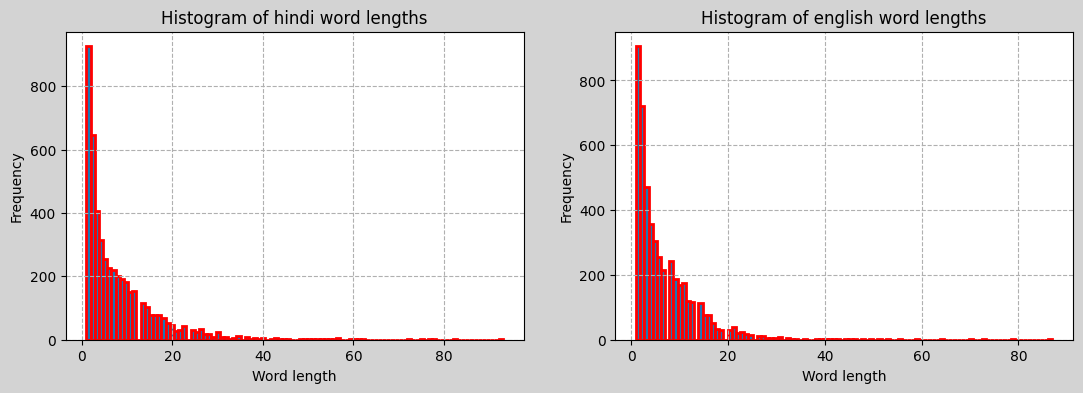

In [26]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.hist(hin_lengths, bins = 100, edgecolor='red',linewidth=2)
plt.gcf().set_facecolor('lightgrey')
plt.title('Histogram of hindi word lengths')
plt.xlabel('Word length')
plt.ylabel('Frequency')
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.hist(eng_lengths, bins = 100, edgecolor='red',linewidth=2)
plt.gcf().set_facecolor('lightgrey')
plt.title('Histogram of english word lengths')
plt.xlabel('Word length')
plt.ylabel('Frequency')
plt.grid(linestyle='--')

plt.show()

It can be observed from the above histograms that the distribution of word lengths for both hindi and english are skewed towards right. The following things can be inferred.<br>
* There are more sentences with less number of words in text in both english and hindi languages for the given data.<br>

In [27]:
for i in [99,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(hin_lengths, i))

99 38.0
99.1 40.0
99.2 43.0
99.3 43.99399999999969
99.4 46.0
99.5 50.0
99.6 53.56800000000021
99.7 56.426000000000386
99.8 59.28399999999965
99.9 72.4260000000022
100 93.0


These percentiles give us an idea of the spread and distribution of lengths within the list hin_lengths. The 99.9th percentile is 72 suggests that the vast majority of data points have a length of 72 or less, with only a very small fraction having lengths greater than that.

In [28]:
for i in [99, 99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

99 31.0
99.1 32.0
99.2 33.0
99.3 35.987999999999374
99.4 39.0
99.5 42.0
99.6 43.56800000000021
99.7 46.0
99.8 51.5679999999993
99.9 64.85200000000441
100 87.0


Within the eng_lengths list, the 99.9th percentile is ~65 suggests that the vast majority of data points have a length of 65 or less, with only a very small fraction having lengths greater than that.

In [29]:
cleaned_data['hindi_len'] = cleaned_data['hindi'].str.split().apply(len)
cleaned_data = cleaned_data[cleaned_data['hindi_len'] < 72]

cleaned_data['english_len'] = cleaned_data['english'].str.split().apply(len)
cleaned_data = cleaned_data[cleaned_data['english_len'] < 65]

# Prepend '<start>' to the beginning of each English sentence. This modified English
# sentence will be used as input during training.
cleaned_data['hindi_inp'] = '<start> ' + cleaned_data['hindi'].astype(str)

# Append '<end>' to the end of each English sentence. This modified English sentence
# will be used as the target output during training.
cleaned_data['hindi_out'] = cleaned_data['hindi'].astype(str) + ' <end>'

final_data = cleaned_data.drop(['hindi','hindi_len','english_len'], axis=1)
final_data.head()

,english,hindi_inp,hindi_out
0,look link bang found one,<start> लिंक देखने धमाके मिल,लिंक देखने धमाके मिल <end>
1,allah god king holy peace giver security overs...,<start> वही ख़ुदा जिसके सिवा क़ाबिले इबादत नही...,वही ख़ुदा जिसके सिवा क़ाबिले इबादत नहीं हक़ीक़...
2,solubility powder tested,<start> पाउडर विलयनशीलता परीक्षण,पाउडर विलयनशीलता परीक्षण <end>
3,gods would entered remain forever,<start> सच्चे माबूद दोज़ख़ जाना पड़ता सबके सब ...,सच्चे माबूद दोज़ख़ जाना पड़ता सबके सब हमेशा रह...
4,surely believe good deeds place entertainment ...,<start> निश्चय लोग ईमान लाए उन्होंने अच्छे कर्...,निश्चय लोग ईमान लाए उन्होंने अच्छे कर्म आतिथ्य...


In [30]:
# Splitting the data into train and test in the ratio 70:30 respectively
train, test = train_test_split(final_data, test_size=0.30)

In [31]:
train['hindi_inp'].iloc[0] = train['hindi_inp'].iloc[0] + ' <end>'

In [32]:
print(train.shape)
print(test.shape)

(3395, 3)
(1455, 3)


In [33]:
tokenize_eng = Tokenizer(filters='')
tokenize_eng.fit_on_texts(train['english'].values)
tokenize_hin = Tokenizer(filters='')
tokenize_hin.fit_on_texts(train['hindi_inp'].values)

In [34]:
vocab_size_eng = len(tokenize_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_hin = len(tokenize_hin.word_index.keys())
print(vocab_size_hin)

8471
9495


In [35]:
tokenize_hin.word_index['<start>'], tokenize_hin.word_index['<end>']

(1, 3412)

In [36]:
sequences_eng = tokenize_eng.texts_to_sequences(train['english'].values)
max_len_eng   = max(len(s) for s in sequences_eng)
print(max_len_eng)

56


In [37]:
sequences_hin = tokenize_hin.texts_to_sequences(train['hindi_inp'].values)
max_len_hin   = max(len(s) for s in sequences_hin)
print(max_len_hin)

62


In [38]:
word2idx_inputs   = tokenize_eng.word_index
word2idx_outputs  = tokenize_hin.word_index

In [39]:
idx2word_inputs  = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

In [40]:
batch_size = 64

In [41]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,vocab_size,embedding_dim,encoder_units,input_length):
      super().__init__()

      self.vocab_size    = vocab_size
      self.embedding_dim = embedding_dim
      self.input_length  = input_length
      self.encoder_units = encoder_units
      self.embedding     = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           name="Encoder_Embedding_Layer")
      self.lstm          = LSTM(self.encoder_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence,states):

      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
      '''
      input_embed                            = self.embedding(input_sequence)
      lstm_output,lstm_state_h, lstm_state_c = self.lstm(input_embed,initial_state=states)
      return lstm_output, lstm_state_h, lstm_state_c

    def initialize_states(self,batch_size):

      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      lstm_state_h = tf.zeros([batch_size,self.encoder_units],dtype=tf.dtypes.float32)
      lstm_state_c = tf.zeros([batch_size,self.encoder_units],dtype=tf.dtypes.float32)
      return lstm_state_h,lstm_state_c

In [42]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,vocab_size, embedding_dim, decoder_units,input_length):
      super().__init__()
      self.vocab_size       = vocab_size
      self.embedding_dim    = embedding_dim
      self.input_length     = input_length
      self.decoder_units    = decoder_units
      self.embedding     = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           name="embedding_layer_decoder")
      self.lstm          = LSTM(self.decoder_units, return_state=True, return_sequences=True, name="Decoder_LSTM")

    def call(self,target_sentence,states):

      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm

          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
      '''
      target_embed                                                = self.embedding(target_sentence)
      decoder_output,decoder_final_state_h,decoder_final_state_c  = self.lstm(target_embed,states)
      return decoder_output,decoder_final_state_h,decoder_final_state_c

In [43]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self,vocab_size_eng,vocab_size_hin, embedding_dim_eng,
                 embedding_dim_hin, input_length_eng,input_length_hin, encoder_units,decoder_units):
      super().__init__()
      self.vocab_size_eng       =  vocab_size_eng
      self.vocab_size_hin       =  vocab_size_hin
      self.embedding_dim_eng    =  embedding_dim_eng
      self.embedding_dim_hin    =  embedding_dim_hin
      self.input_length_eng     =  input_length_eng
      self.input_length_hin     =  input_length_hin
      self.encoder_units        =  encoder_units
      self.decoder_units        =  decoder_units
      self.encoder   = Encoder(vocab_size=self.vocab_size_eng+1,embedding_dim=self.embedding_dim_eng
                               ,encoder_units=self.encoder_units,input_length=self.input_length_eng)
      self.decoder   = Decoder(vocab_size=self.vocab_size_hin+1,embedding_dim=self.embedding_dim_hin
                               ,decoder_units=self.decoder_units,input_length=self.input_length_hin)
      self.dense     = Dense(self.vocab_size_hin, activation='softmax') #

    def call(self,data):
      '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer
        Return decoder_outputs
      '''

      input,output   =   data[0],data[1]
      initial_state  =   self.encoder.initialize_states(batch_size=batch_size)

      encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
      states         =   [encoder_h,encoder_c]
      decoder_output,decoder_h, decoder_c =   self.decoder(output, states)
      output          =   self.dense(decoder_output)
      return output

In [44]:
class Dataset:
    def __init__(self, data, tokenize_hin, tokenize_eng, max_len_hin, max_len_eng):
        self.encoder_inps = data['english'].values
        self.decoder_inps = data['hindi_inp'].values
        self.decoder_outs = data['hindi_out'].values
        self.tokenize_eng = tokenize_eng
        self.tokenize_hin = tokenize_hin
        self.max_len_hin = max_len_hin
        self.max_len_eng = max_len_eng

    def __getitem__(self, i):
        self.encoder_seq     = self.tokenize_hin.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenize_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenize_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq     = pad_sequences(self.encoder_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_hin, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_hin, dtype='int32', padding='post')

        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [45]:
train_dataset = Dataset(train, tokenize_hin, tokenize_eng, max_len_hin, max_len_eng)
test_dataset  = Dataset(test, tokenize_hin, tokenize_eng, max_len_hin, max_len_eng)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader  = Dataloder(test_dataset, batch_size=batch_size)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

(64, 56) (64, 62) (64, 62)
(64, 56) (64, 62) (64, 62)


In [46]:
class SaveBestWeightsCallback(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        super(SaveBestWeightsCallback, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = float('inf') if mode == 'min' else float('-inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            self.best = current
            self.model.save_weights(self.filepath, overwrite=True)
            print(f"\nSaved best weights to {self.filepath} -- {self.monitor}: {current:.4f}")

In [49]:
model = Encoder_decoder(vocab_size_eng=vocab_size_eng,vocab_size_hin=vocab_size_hin,
                        embedding_dim_eng=150, embedding_dim_hin=150,
                        input_length_eng=train_dataloader[0][0][0].shape[-1],
                        input_length_hin=train_dataloader[0][0][1].shape[-1],
                        encoder_units=32,
                        decoder_units=32)

model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

train_steps = train.shape[0]//batch_size
test_steps  = test.shape[0]//batch_size

In [50]:
save_best_callback = SaveBestWeightsCallback(filepath='/content/drive/MyDrive/Language_translation/custom_model.h5',
                                             monitor='val_loss', mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1,mode='min')
lr_handling    = ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                                   patience=2,verbose=1,mode='min')
model.fit(train_dataloader,
          validation_data  = test_dataloader,
          steps_per_epoch  = train_steps,
          validation_steps = test_steps,
          epochs = 50,
          callbacks = [save_best_callback,early_stopping,lr_handling])

Epoch 1/50
52/53 [============================>.] - ETA: 0s - loss: 7.9762 - sparse_categorical_accuracy: 0.9615
Saved best weights to /content/drive/MyDrive/Language_translation/custom_model.h5 -- val_loss: 5.5460
53/53 [==============================] - 15s 113ms/step - loss: 7.9324 - sparse_categorical_accuracy: 0.9623 - val_loss: 5.5460 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50
52/53 [============================>.] - ETA: 0s - loss: 3.1371 - sparse_categorical_accuracy: 1.0000
Saved best weights to /content/drive/MyDrive/Language_translation/custom_model.h5 -- val_loss: 1.1163
53/53 [==============================] - 3s 51ms/step - loss: 3.0998 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1163 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.4815 - sparse_categorical_accuracy: 1.0000
Saved best weights to /content/drive/MyDrive/Language_translation/custom_model.h5 -- val_loss

In [51]:
model.summary(line_length=100,expand_nested=True)

Model: "encoder_decoder_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 encoder_1 (Encoder)                         multiple                                1294224        
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Encoder_Embedding_Layer (Embedding)        multiple                                1270800       |
|                                                                                                  |
| Encoder_LSTM (LSTM)                        multiple                                23424         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder_1 (Decoder)                         multiple                                1447824        
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

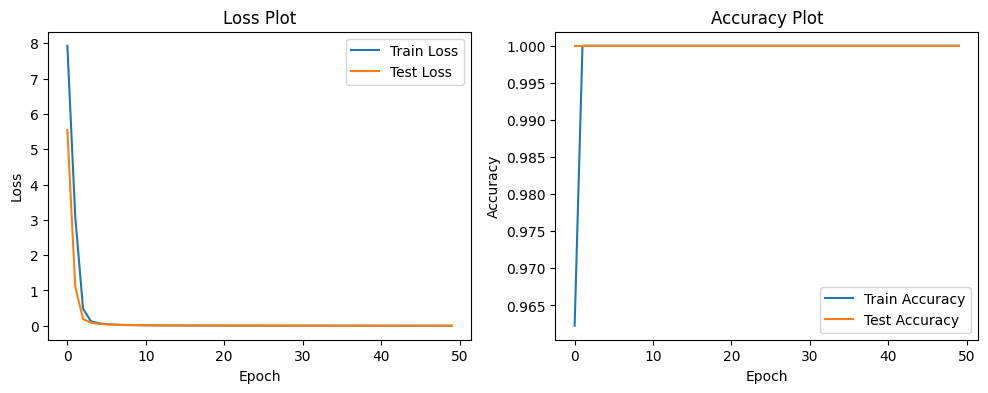

In [53]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_sparse_categorical_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()

plt.show()

In [54]:
# Function to generate predictions for a given input sequence
def generate_predictions(input_sequence):
    input_sequence    = pad_sequences(tokenize_eng.texts_to_sequences([input_sequence]), maxlen=max_len_eng, dtype='int32', padding='post')
    en_h,en_c         = model.layers[0].initialize_states(1)
    en_outputs        = model.layers[0](tf.constant(input_sequence), [en_h,en_c])
    de_input          = tf.constant([[word2idx_outputs['<start>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    while True:
        de_output, de_state_h, de_state_c = model.layers[1](de_input, [de_state_h, de_state_c])
        output      =   model.layers[2](de_output)
        output      =   tf.argmax(output, -1)
        out_words.append(idx2word_outputs[output.numpy()[0][0]+1])
        if out_words[-1] == '<end>' or len(out_words) >= max_len_hin:
          break
        de_input    = output
    return ' '.join(out_words)

In [56]:
# Select a random sample of 5 from the test dataset
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)

# Get predictions for the selected samples and compare with original sequences
for idx in sample_indices:
    input_sequence = test_dataset.encoder_inps[idx]
    target_sequence = ' '.join(test_dataset.decoder_outs[idx].split()[:-1])
    predicted_sequence = generate_predictions(input_sequence)
    print("Input Sequence:", input_sequence)
    print("Target Sequence:", target_sequence)
    print("Predicted Sequence:", predicted_sequence)
    print("-------------------------------")

Input Sequence: file
Target Sequence: फ़ाइल नहीं
Predicted Sequence: <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start>
-------------------------------
Input Sequence: creating unless specific use
Target Sequence: विशिष्ट उपयोग के आईटी बनाना
Predicted Sequence: <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <start> <star

In [69]:
import pickle
with open('/content/drive/MyDrive/Language_translation/tokenizer_eng.pickle', 'wb') as file:
    pickle.dump(tokenize_eng, file,protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
with open('/content/drive/MyDrive/Language_translation/tokenizer_hin.pkl', 'wb') as file:
    pickle.dump(tokenize_hin, file)

In [59]:
with open('/content/drive/MyDrive/Language_translation/word2idx_outputs.pkl', 'wb') as file:
    pickle.dump(word2idx_outputs, file)

In [60]:
with open('/content/drive/MyDrive/Language_translation/idx2word_outputs.pkl', 'wb') as file:
    pickle.dump(idx2word_outputs, file)

In [61]:
with open('/content/drive/MyDrive/Language_translation/streamlit_app.py','wb') as file:
  pass